# scNT-seq

scNT-seq ([Qiu, Hu, et al 2020](https://www.nature.com/articles/s41592-020-0935-4)) is a recently proposed  technique to metabolically label newly synthesied RNAs in single cells. By using the labelling information, the inferred cellular transitions by [Dynamo](https://dynamo-release.readthedocs.io/en/latest/scNT_seq_readthedocs.html) are hihgly consistent with the stimulation time (see [our reproduced analysis](https://github.com/huangyh09/brie-tutorials/blob/main/scNTseq/dynamo_scNTseq.ipynb) with scripts from the authors).

This relative-longe-period transition is generally difficult to be obtained from RNA velocity by only using total RNAs. Here, we will illustrate that the differential momentum genes could help correct the projected trajectory, thanks to using the stimulation time as a testing (i.e., supervised) covariate.

As BRIE2 takes ~30 minutes with GPU to detect the DMGs, we provide the [pre-computed data](https://sourceforge.net/projects/brie-rna/files/examples/scNTseq/) with [these BRIE2 scripts](https://github.com/huangyh09/brie-tutorials/blob/main/scNTseq/run_brie2.sh).
You can run this notebook by downloading the data, e.g., using the following command line and unzip it into the `./data` folder:

```bash
wget http://ufpr.dl.sourceforge.net/project/brie-rna/examples/scNTseq/brie2_scNTseq.zip
unzip -j brie2_scNTseq.zip -d ./data
```

## Load packages

In [1]:
import brie
import numpy as np
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt
scv.logging.print_version()

2021-09-23 21:25:04.656553: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-23 21:25:04.656584: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Running scvelo 0.2.4 (python 3.7.6) on 2021-09-23 21:25.


DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.
ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI's XMLRPC API is currently disabled due to unmanageable load and will be deprecated in the near future. See https://status.python.org/ for more information.


In [2]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization

In [3]:
# define the path you store the example data
# dat_dir = "./data"
dat_dir = '/storage/yhhuang/research/brie2/releaseDat/scNTseq/'

## scVelo dynamical model with total RNAs

This may take a few minutes to run, so we provide the pre-computed the data as in the above zip file for the setting with top 2,000 genes. The commented Python scripts are below. 
You can get the `neuron_splicing_totalRNA.h5ad` from here generated by [the adapted script](https://github.com/huangyh09/brie-tutorials/blob/main/scNTseq/scNTseq_data_combine.ipynb). If you want to change to more hihgly variable genes, you can change `n_top_genes` to other value, e.g., 8000.

```Python
adata = scv.read(dat_dir + "/neuron_splicing_totalRNA.h5ad")

scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

scv.tl.recover_dynamics(adata, var_names='all')
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)
scv.tl.latent_time(adata)
adata.write(dat_dir + "/scvelo_neuron_totalRNA_dynamical_2K.h5ad")
```

### Cellular transitions on default selected velocity genes

In [4]:
adata = scv.read(dat_dir + "/scvelo_neuron_totalRNA_dynamical_2K.h5ad")

print(adata.shape, np.sum(adata.var['velocity_genes']))
adata

(3066, 1999) 132


AnnData object with n_obs × n_vars = 3066 × 1999
    obs: 'cellname', 'time', 'early', 'late', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'gene_short_name', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'fit_r2', 'velocity_genes'
    uns: 'neighbors', 'pca', 'recover_dynamics', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


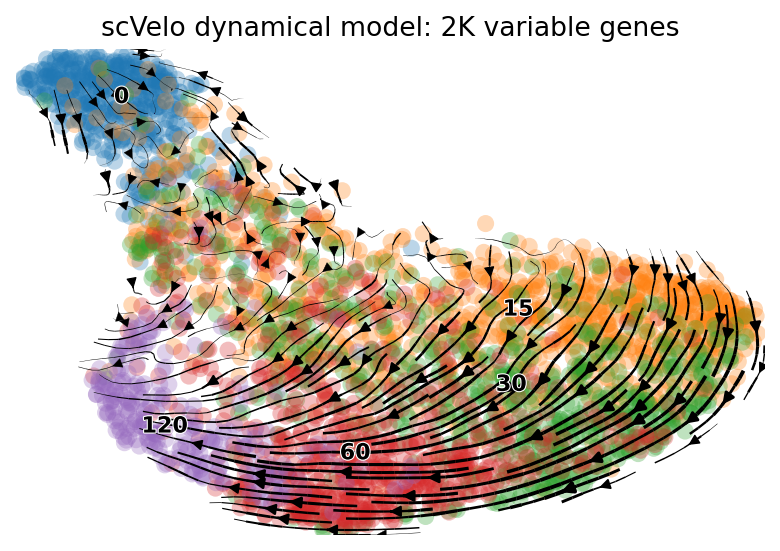

In [5]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color=['time'], 
                                 ax=None, show=True, legend_fontsize=10, dpi=80,
                                 title='scVelo dynamical model: 2K variable genes')

#### For 8K top variable genes
You can skip this sub section if not using the 8K top genes

```Python
adata2 = scv.read(dat_dir + "/scvelo_neuron_totalRNA_dynamical_8K.h5ad")
print(adata2.shape, np.sum(adata2.var['velocity_genes']))

scv.pl.velocity_embedding_stream(adata2, basis='umap', color=['time'], 
                                 ax=None, show=True, legend_fontsize=10, 
                                 title='scVelo dynamical model: 8K variable genes')
```

## BRIE2 for differential momentum genes (DMGs)

Besides the large h5ad file, BRIE2 also saves the DMGs in a .tsv file [brie_neuron_splicing_time.brie_ident.tsv](https://github.com/huangyh09/brie-tutorials/blob/main/scNTseq/data/brie_neuron_splicing_time.brie_ident.tsv) for quick access.

In [6]:
adata_brie = scv.read(dat_dir + "/brie_neuron_splicing_time.h5ad")

adata_brie

AnnData object with n_obs × n_vars = 3066 × 7849
    obs: 'cellname', 'time', 'early', 'late'
    var: 'gene_short_name', 'n_counts', 'n_counts_uniq', 'loss_gene'
    uns: 'Xc_ids', 'brie_losses', 'brie_param', 'brie_version'
    obsm: 'X_umap', 'Xc'
    varm: 'ELBO_gain', 'cell_coeff', 'fdr', 'intercept', 'pval', 'sigma'
    layers: 'Psi', 'Psi_95CI', 'Z_std', 'spliced', 'unspliced'

<Figure size 360x240 with 0 Axes>

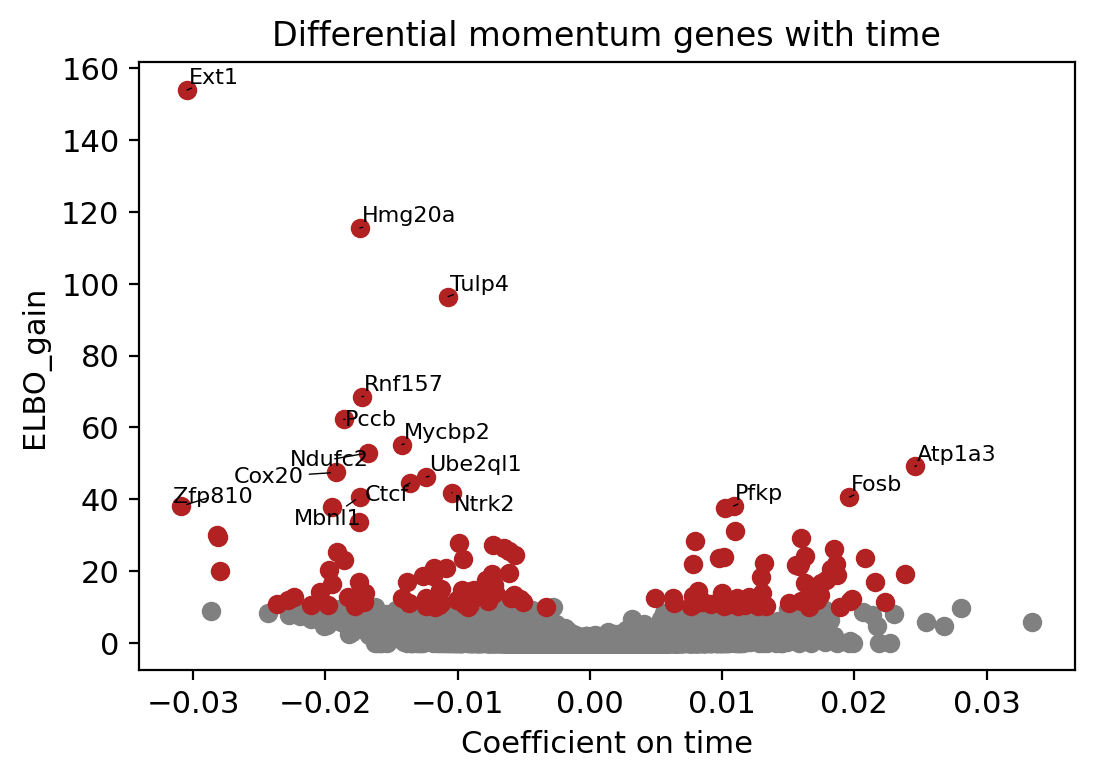

In [7]:
fig = plt.figure(figsize=(6, 4), dpi=60)
plt.figure(figsize=(6, 4), dpi=100)
brie.pl.volcano(adata_brie, y='ELBO_gain', log_y=False, n_anno=16, 
        score_red=10, adjust=True)
plt.title('Differential momentum genes with time')
plt.xlabel('Coefficient on time')
# plt.savefig(dat_dir + '../../figures/scNT_volcano_elbo.png', dpi=200)
plt.show()

### RNA velocity on DMGs 

421 201
computing velocity graph (using 1/80 cores)



    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


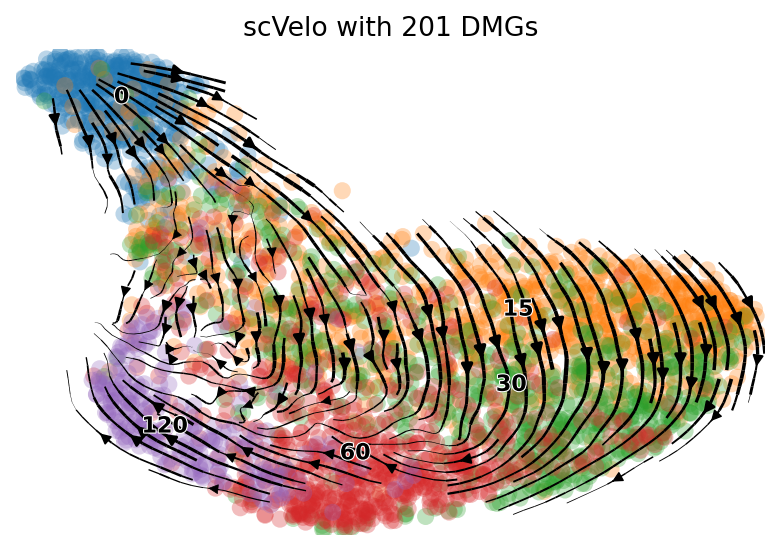

In [8]:
idx = (np.min(adata_brie.varm['ELBO_gain'], axis=1) > 5)
gene_use = adata_brie.var.index[idx]
print(sum(idx), sum(brie.match(gene_use, adata.var.index) != None))
n_genes = sum(brie.match(gene_use, adata.var.index) != None)

scv.tl.velocity_graph(adata, gene_subset=gene_use)
scv.pl.velocity_embedding_stream(adata, basis='umap', color=['time'], 
                                 legend_fontsize=10,
                                 ax=None, show=True, dpi=80,
                                 title='scVelo with %d DMGs' %(n_genes))

### Change cutoffs

##### With ELBO_gain>7 or with ELBO_gain > 3

239 122
computing velocity graph (using 1/80 cores)



    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
815 360
computing velocity graph (using 1/80 cores)



    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


Text(-0.15, 0.95, 'b')

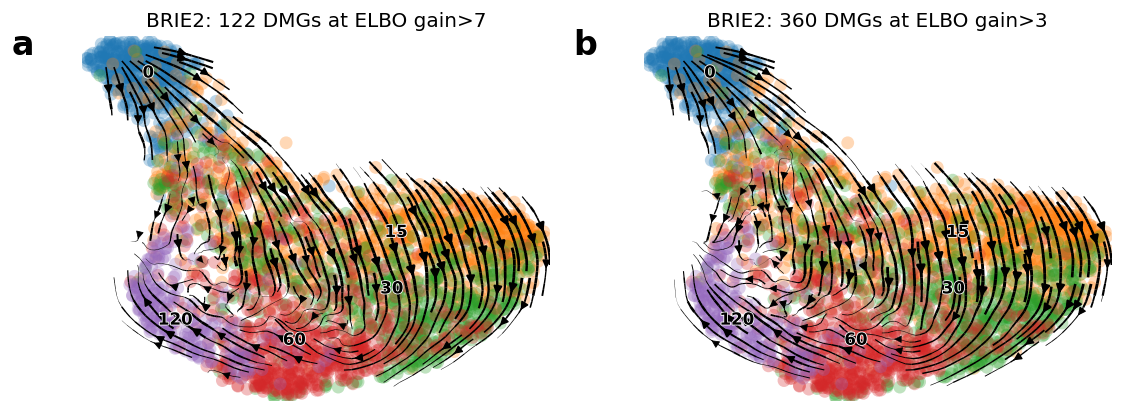

In [9]:
fig = plt.figure(figsize=(11, 4), dpi=60)

ax1 = plt.subplot(1, 2, 1)
idx1 = (np.min(adata_brie.varm['ELBO_gain'], axis=1) > 7)
gene_use1 = adata_brie.var.index[idx1]
print(sum(idx1), sum(brie.match(gene_use1, adata.var.index) != None))

scv.tl.velocity_graph(adata, gene_subset=gene_use1)
scv.pl.velocity_embedding_stream(adata, basis='umap', color=['time'], 
                                 ax=ax1, show=False, legend_fontsize=10, 
                                 title='BRIE2: %d DMGs at ELBO_gain>7'
                                 %(sum(brie.match(gene_use1, adata.var.index) != None)))
ax1.text(-0.15, 0.95, 'a', transform=ax1.transAxes, size=20, weight='bold')


ax2 = plt.subplot(1, 2, 2)
idx2 = (np.min(adata_brie.varm['ELBO_gain'], axis=1) > 3)
gene_use2 = adata_brie.var.index[idx2]
print(sum(idx2), sum(brie.match(gene_use2, adata.var.index) != None))

scv.tl.velocity_graph(adata, gene_subset=gene_use2)
scv.pl.velocity_embedding_stream(adata, basis='umap', color=['time'],
                                 ax=ax2, show=False, legend_fontsize=10, 
                                 title='BRIE2: %d DMGs at ELBO_gain>3'
                                 %(sum(brie.match(gene_use2, adata.var.index) != None)))
ax2.text(-0.15, 0.95, 'b', transform=ax2.transAxes, size=20, weight='bold')

# plt.tight_layout()
# plt.savefig(dat_dir + '../../figures/scNT_scVelo_brie_ELBO.png', dpi=300)
# plt.show()

### Visualize gene count

In [10]:
idx = (np.min(adata_brie.varm['ELBO_gain'], axis=1) > 5)
gene_use = adata_brie.var.index[idx]

mm = brie.match(gene_use, adata.var.index) != None
gene_use[mm]

Index(['Ncor1', 'App', 'Meis2', 'Cdk2ap1', 'Usp24', 'Ahi1', 'Tcf4', 'Nup98',
       'Zswim6', 'Fam155a',
       ...
       'Epha3', 'Pcca', 'Ptk2', 'Zbtb20', 'Nell2', 'Zbtb11', 'Pccb', 'Frem2',
       'Celf4', 'Zfp704'],
      dtype='object', length=201)

In [11]:
## sorted by ELBO gain
idx_sort = np.argsort(adata_brie[:, gene_use[mm]].varm['ELBO_gain'][:,0])[::-1]
gene_use[mm][idx_sort]

Index(['Ext1', 'Pccb', 'Ube2ql1', 'Ntrk2', 'Mbnl1', 'Fosb', 'Pfkp', 'Orc5',
       'Srd5a1', 'Chka',
       ...
       'Osgep', 'Nrn1', 'Ddx3y', 'Napb', 'Zdhhc17', 'Snap25', 'Ccnl1', 'Cobl',
       'Etv5', 'Lats2'],
      dtype='object', length=201)

In [12]:
## Only negative coefficient
gene_sorted = gene_use[mm][idx_sort]
gene_sorted[adata_brie[:, gene_sorted].varm['cell_coeff'][:, 0] < 0]

Index(['Ext1', 'Pccb', 'Ube2ql1', 'Ntrk2', 'Mbnl1', 'Orc5', 'Srd5a1', 'Akap9',
       'Ank2', 'Dlgap1',
       ...
       'Ptpre', 'Klhl4', 'Kcnn2', 'Zfp292', 'Osgep', 'Napb', 'Zdhhc17',
       'Snap25', 'Cobl', 'Etv5'],
      dtype='object', length=129)

In [13]:
## Only positive coefficient
gene_sorted = gene_use[mm][idx_sort]
gene_sorted[adata_brie[:, gene_sorted].varm['cell_coeff'][:, 0] > 0]

Index(['Fosb', 'Pfkp', 'Chka', 'Homer1', 'Erf', 'Nup98', 'Ifrd1', 'Ncapg2',
       'Rasgef1b', 'Rsrp1', 'Tiparp', 'Crem', 'Zdbf2', 'Arl5b', 'Usp37',
       'Fam107b', 'Elmsan1', 'Cwc25', 'Nedd9', 'Cystm1', 'Atp9a', 'Fosl2',
       'Stil', 'Arih1', 'Ldlr', 'Ak4', 'Zfp248', 'Elovl5', 'Pde4d', 'Nr4a2',
       'Nufip2', 'Mpped1', 'Srsf5', 'Fgfr2', 'Gtf2i', 'Gpr19', 'Cpeb3',
       'Fbxo33', 'Srrm2', 'Dcun1d3', 'Foxo3', 'Zswim6', 'Ccdc138', 'Zbtb11',
       'Cramp1l', 'Ndel1', 'Aff4', 'Arf4', 'Slc2a3', 'Stk40', 'Baiap2',
       'Slc20a1', 'Cabp1', 'Gla', 'Gltscr2', 'Ptprk', 'Rasgrf1', 'Cpeb2',
       'Snapc1', 'Pkia', 'Sik1', 'Nr4a1', 'Ppm1d', 'Cdk2ap1', 'Impact', 'Plaa',
       'Hpf1', 'Taf1', 'Nrn1', 'Ddx3y', 'Ccnl1', 'Lats2'],
      dtype='object')

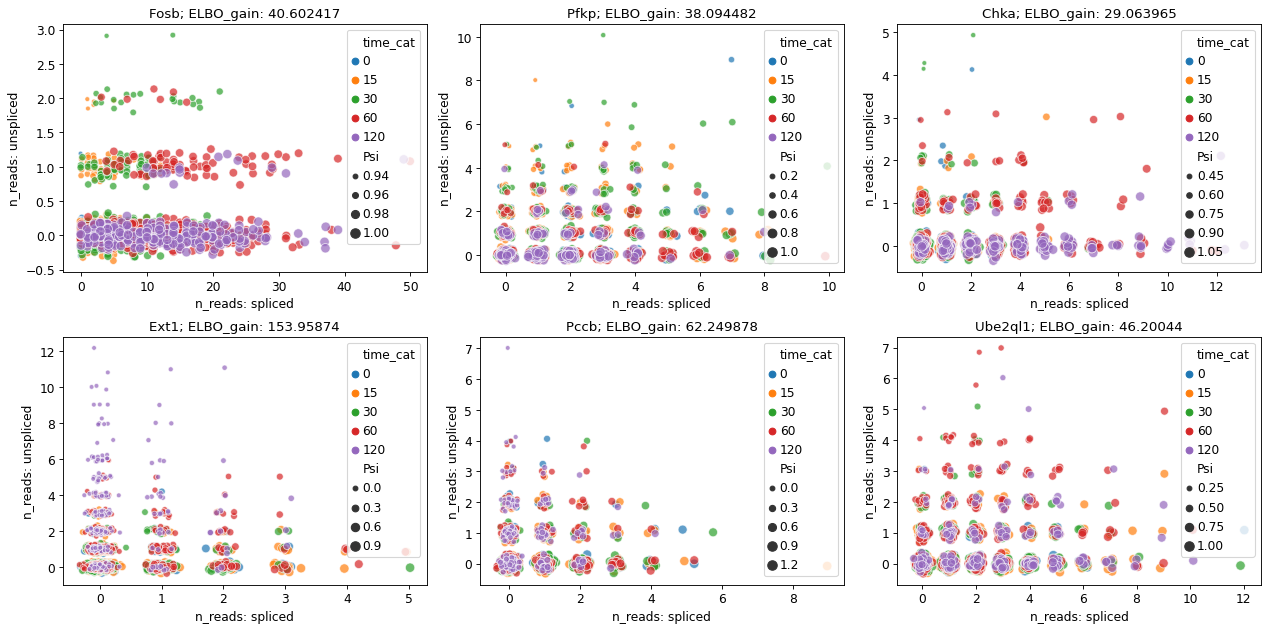

In [14]:
adata_brie.obs['time_cat'] = adata_brie.obs['time'].astype('category')

gene_top_neg = ['Ext1', 'Pccb', 'Ube2ql1']
gene_top_pos = ['Fosb', 'Pfkp', 'Chka']

fig = plt.figure(figsize=(16, 8), dpi=40)
brie.pl.counts(adata_brie, genes=gene_top_pos + gene_top_neg, 
               layers=['spliced', 'unspliced'],
               color='time_cat', add_val='ELBO_gain', 
               ncol=3, alpha=0.7, legend='brief', noise_scale=0.1)

# plt.savefig(dat_dir + '../../figures/scNT_DMG_counts.png', dpi=150)
# plt.show()

In [15]:
adata_brie[:, gene_top_pos + gene_top_neg].varm['cell_coeff']

ArrayView([[ 0.0196298 ],
           [ 0.01087456],
           [ 0.01594826],
           [-0.03045544],
           [-0.0186206 ],
           [-0.01236648]], dtype=float32)

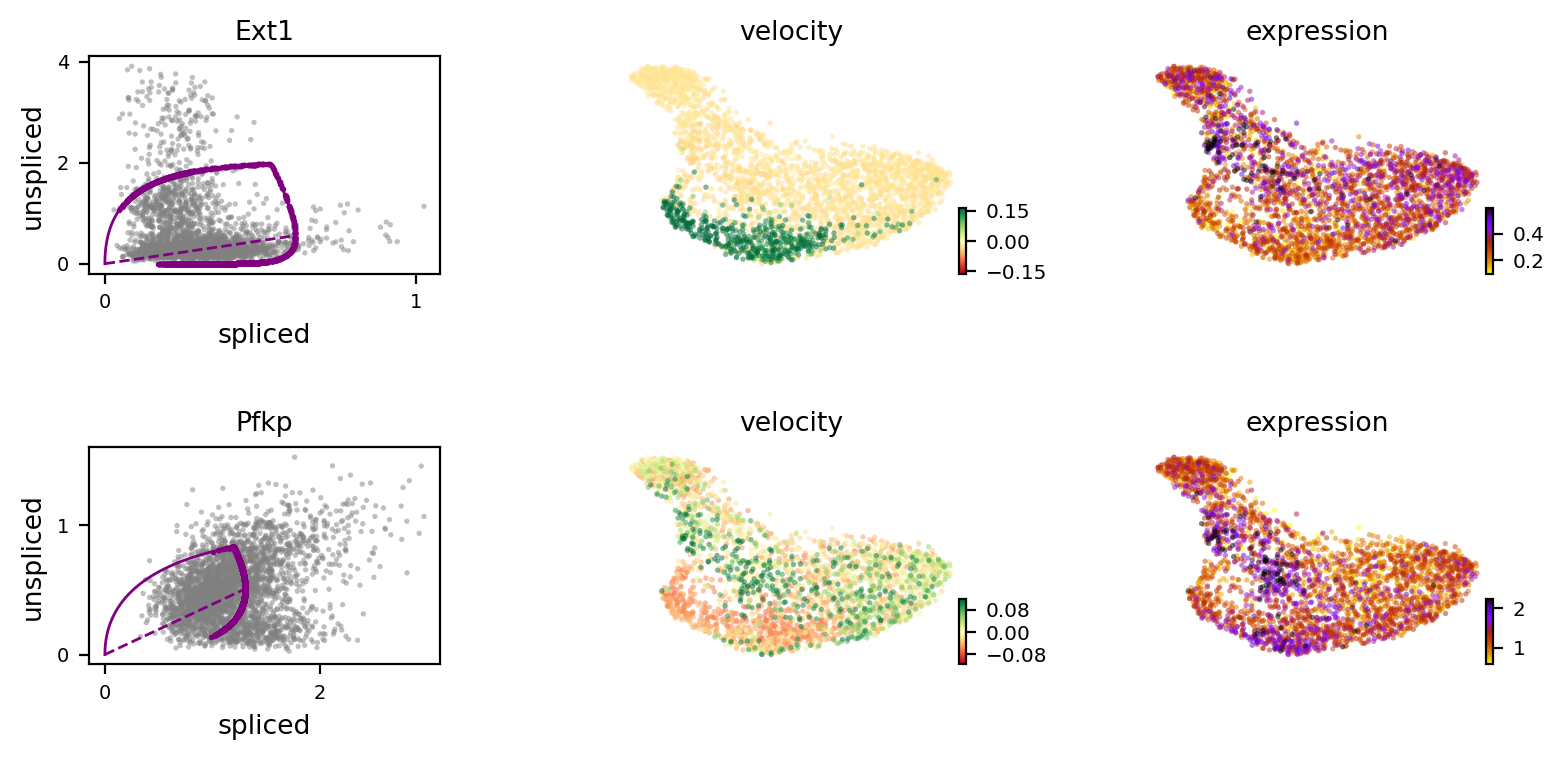

In [16]:
scv.pl.velocity(adata, var_names=['Ext1', 'Pfkp'], colorbar=True, ncols=1)